In [1]:
import numpy as np
import os
from random import shuffle
import time
import csv

import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers, losses, activations, applications
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

from skimage.transform import resize
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard

# used to download pretrained Inception V3 Keras Model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 

#DATA_DIR = "/home/spa/coin-vision/ssd-data/all-68-20190123-keras-no-noise/"
DATA_DIR = "/home/spa/coin-vision/ssd-data/micro-25-20190204/"

MODEL_LABELS_FILE_PATH = DATA_DIR + "labels.txt"
MODEL_FILE_PATH = DATA_DIR + "inception_v3_" + time.strftime("%Y%m%d-%H%M%S") + ".hdf5"

train_epochs=5
ROWS=299
COLS=299

train_batch_size = 64
validation_batch_size = 100



tensorboard_log_dir = DATA_DIR + 'logs/'
tensorboard = TensorBoard(log_dir=tensorboard_log_dir)

print('tensorflow version', tf.__version__)
print('TensorBoard log dir: ', tensorboard_log_dir)
print('MODEL_FILE_PATH: ', MODEL_FILE_PATH)




Using TensorFlow backend.


tensorflow version 1.12.0
TensorBoard log dir:  /home/spa/coin-vision/ssd-data/micro-25-20190204/logs/


In [2]:
list_paths = []
for subdir, dirs, files in os.walk(DATA_DIR):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        list_paths.append(filepath)

In [3]:
list_train = [filepath for filepath in list_paths if "labeled-images-tr/" in filepath]
list_test = [filepath for filepath in list_paths if "labeled-images-tst/" in filepath]

validation_steps = len(list_test) / validation_batch_size # images-in-test / val-batch-size

In [4]:
train_idg = ImageDataGenerator(
                               vertical_flip=False,
                               horizontal_flip=False,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               rotation_range=20,
                               zoom_range=0.2,
                               shear_range=0.2,
                               preprocessing_function=preprocess_input)

test_idg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tr/',
    target_size=(ROWS, COLS),
    batch_size = train_batch_size
)
test_gen = test_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tst/',
    target_size=(ROWS, COLS),
    batch_size = validation_batch_size,
    shuffle = True
)


Found 68500 images belonging to 25 classes.
Found 4000 images belonging to 25 classes.


In [5]:
#labels

In [6]:
labels = test_gen.class_indices.items()

# save to file (is used during prediction)
with open(MODEL_LABELS_FILE_PATH, 'w') as outfile:
    w = csv.writer(outfile)
    for key, value in labels:
        w.writerow([key, str(value)])

# load from file (to make sure same labels are used during train & prediction)
with open(MODEL_LABELS_FILE_PATH, mode='r') as infile:
    reader = csv.reader(infile)
    labels = {rows[0]:int(float(rows[1])) for rows in reader}
    
labels = labels.items()    

In [7]:
# get a batch sample from training set generator to show sample images and histogram
x,y = train_gen.next()

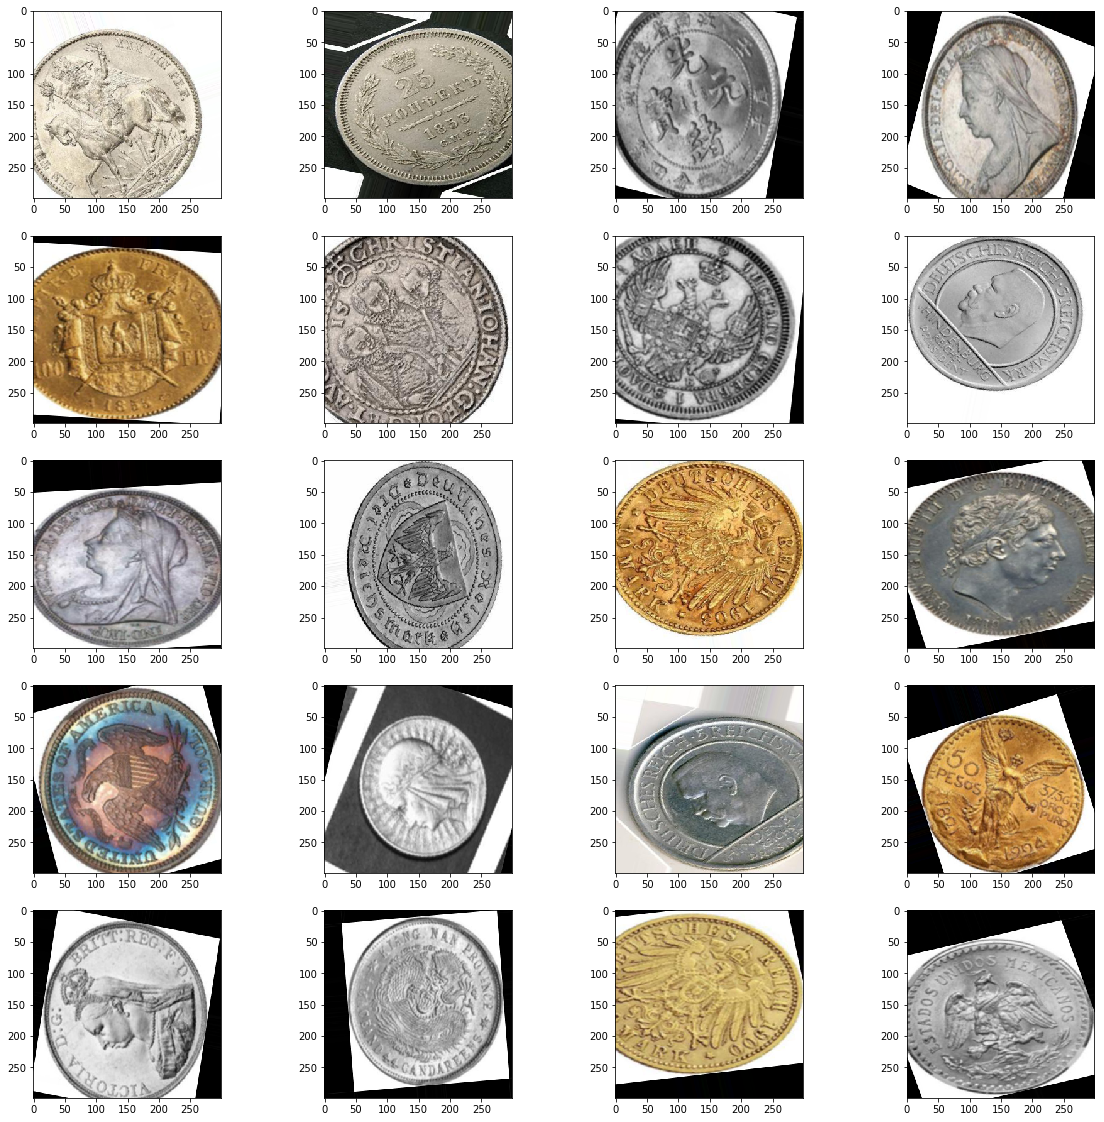

In [19]:
#show some images from train set
# rescale for better view: [-1:1] => [0:255]
img_to_plot_uint8 = (127.5*(x + 1)).astype(np.uint8)
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_to_plot_uint8[i])
plt.show()

show histogram for a train image


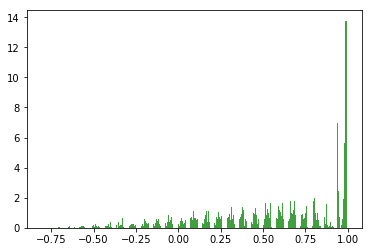

In [22]:
# show histogram for one sample used for training
print('show histogram for a train image')
n, bins, patches = plt.hist(x[0,:,:,1].reshape(ROWS, COLS), 25, density=1, facecolor='green', alpha=0.75)
plt.show()

In [10]:

input_shape = (ROWS, COLS, 3)
nclass = len(labels)

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = True

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
#add_model.add(Dropout(0.3))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                51225     
Total params: 21,854,009
Trainable params: 21,819,577
Non-trainable params: 34,432
_________________________________________________________________


In [11]:
# LOAD MODEL
#model.load_weights(file_path)

tr_steps_per_epoch = len(list_train) / train_batch_size
print('trainig steps per epoc: ', tr_steps_per_epoch)


checkpoint = ModelCheckpoint(MODEL_FILE_PATH, monitor='acc', verbose=1, save_best_only=False, mode='max')

early = EarlyStopping(monitor="acc", mode="max", patience=5)

callbacks_list = [checkpoint, early, tensorboard] #early

history = model.fit_generator(train_gen, 
                              epochs=train_epochs, 
                              steps_per_epoch=tr_steps_per_epoch,
                              shuffle=True, 
                              verbose=True,
                              validation_data=test_gen,
                              validation_steps=validation_steps, # fix me later if works
                              callbacks=callbacks_list)

trainig steps per epoc:  1070.3125
Epoch 1/5
1071/1070 [==============================] - 1460s 1s/step - loss: 0.1218 - acc: 0.9602 - top_k_categorical_accuracy: 0.9963 - val_loss: 0.2654 - val_acc: 0.9187 - val_top_k_categorical_accuracy: 0.9915

Epoch 00001: saving model to /home/spa/coin-vision/ssd-data/micro-25-20190204/inception_v3_20190204-120145.hdf5
Epoch 2/5
1071/1070 [==============================] - 1420s 1s/step - loss: 0.0421 - acc: 0.9862 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.2651 - val_acc: 0.9303 - val_top_k_categorical_accuracy: 0.9970

Epoch 00002: saving model to /home/spa/coin-vision/ssd-data/micro-25-20190204/inception_v3_20190204-120145.hdf5
Epoch 3/5
1071/1070 [==============================] - 1422s 1s/step - loss: 0.0212 - acc: 0.9935 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.2240 - val_acc: 0.9587 - val_top_k_categorical_accuracy: 0.9910

Epoch 00003: saving model to /home/spa/coin-vision/ssd-data/micro-25-20190204/inception_v3_20190204

In [12]:
# RELOAD MODEL from the file (to make sure we use the same model for test/predictions)
model.load_weights(MODEL_FILE_PATH)


In [13]:
# test_gen_final uses same test data as test_idg. The difference is class_mode='binary' (test_idg uses class_mode='categorical' )
test_gen_final = test_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tst/',
    target_size=(ROWS, COLS),
    batch_size = 100,
    shuffle = False,
    class_mode='binary'
)


Found 4000 images belonging to 25 classes.


In [16]:
steps = 40
predicts_label_acc = []
y_true_label_acc = []

# TODO: show some images and histogram from test sequence 

for step in range(steps):
    x_test,y_true = test_gen_final.next()
    predicts = model.predict_classes(x_test)
    label_index = {v: k for k,v in labels}
    predicts_label = [label_index[p] for p in predicts]
    y_true_label = [label_index[p] for p in y_true]
    predicts_label_acc.extend(predicts_label)
    y_true_label_acc.extend(y_true_label)
    print("done ", step, " from ", steps)



done  0  from  40
done  1  from  40
done  2  from  40
done  3  from  40
done  4  from  40
done  5  from  40
done  6  from  40
done  7  from  40
done  8  from  40
done  9  from  40
done  10  from  40
done  11  from  40
done  12  from  40
done  13  from  40
done  14  from  40
done  15  from  40
done  16  from  40
done  17  from  40
done  18  from  40
done  19  from  40
done  20  from  40
done  21  from  40
done  22  from  40
done  23  from  40
done  24  from  40
done  25  from  40
done  26  from  40
done  27  from  40
done  28  from  40
done  29  from  40
done  30  from  40
done  31  from  40
done  32  from  40
done  33  from  40
done  34  from  40
done  35  from  40
done  36  from  40
done  37  from  40
done  38  from  40
done  39  from  40


In [17]:
print(classification_report(predicts_label_acc,y_true_label_acc))


                          precision    recall  f1-score   support

094KbzbiZJIAAAFRCdU1_Hq6       1.00      1.00      1.00       160
0E3BwcI0u2YAAAEr2Y9bGgFN       0.97      0.87      0.91       179
2FrBwcI0y3wAAAEsZRav82Li       1.00      0.96      0.98       166
2YgK.GJAtFgAAAEvNGbi7NnT       0.93      1.00      0.96       148
3XLBwcI0_NUAAAErkJdjEBuu       0.57      0.95      0.71        96
5F8KbzbifW0AAAFMwI3GHitP       0.95      1.00      0.97       152
79fBwcI0oNQAAAEoyct8PEiv       0.89      1.00      0.94       143
7CAKbzbidSgAAAFNm4xmYGUO       0.96      1.00      0.98       154
7LJ_AAEBUvoAAAEjD93APfNR       0.99      0.98      0.98       161
7tUKbzbioxMAAAFF8O0hZfdp       0.97      1.00      0.99       156
8hYKbzbivsUAAAFMbIiKYUob       1.00      0.64      0.78       250
967BwcI05ncAAAEm3.9OQjgv       0.97      0.95      0.96       164
BbXBwcI0x2kAAAEscYXD8Cy_       0.92      1.00      0.96       147
EP_BwcI0tSIAAAEpdnX.2mma       0.93      1.00      0.96       148
EpbBwcI0k